# Определение перспективного тарифа для телеком-компании <a id='intro'></a>

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф «Смарт»**

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
   1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
   2. сообщение: 3 рубля; 
   3. 1 Гб интернет-трафика: 200 рублей.
   
**Тариф «Ультра»**

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
   1. минута разговора: 1 рубль; 
   2. сообщение: 1 рубль; 
   3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение общей информации

Импортируем библиотеки, с которыми будем работать

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats as st
import numpy as np

Работать будем с несколькими источниками данных, поэтому сохраняем:
* информацию о пользователях в переменную `users`,
* информацию о звонках в переменную `calls`,
* ифнормацию о сообщениях в переменную `messages`,
* информацию об интернет-сессиях в переменную `internet`,
* информацию о тарифах в переменную `tariffs`.

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Данные для анализа представлена в 5 таблицах, посмотрим подробную информацию о каждой таблице.

**Информация о клиентах**

Доступные данные:
1. user_id - уникальный идентификатор пользователя
2. first_name — имя пользователя
3. last_name — фамилия пользователя
4. age — возраст пользователя (годы)
5. reg_date — дата подключения тарифа (день, месяц, год)
6. churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
7. city — город проживания пользователя
8. tarif — название тарифного плана

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице представлены данные по 500 абонентам, которые пользуются двумя тарифными планами - "Смарт" и "Ультра". В столбце "Дата прекращения пользования тарифом" есть 38 заполненных значений, значит 38 клиентов перестали пользоваться услугами компании.

Посмотрим следующую таблицу.

**Информация о звонках**

Доступные данные:
1. id — уникальный номер звонка
2. call_date — дата звонка
3. duration — длительность звонка в минутах
4. user_id — идентификатор пользователя, сделавшего звонок

In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице о звонках 202607 строк и 4 столбца.

Посмотрим следующую таблицу.

**Информация о сообщениях**

Доступные данные:
1. id — уникальный номер сообщения
2. message_date — дата сообщения
3. user_id — идентификатор пользователя, отправившего сообщение

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице о сообщениях 123036 строк и 4 столбца. 

Посмотрим следующую таблицу.

**Информация об интернет-сессиях**

Доступные данные:
1. id — уникальный номер сессии
2. mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
3. session_date — дата интернет-сессии
4. user_id — идентификатор пользователя

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице об интернет-сессиях 149396 строк и 5 столбцов. 

Посмотрим следующую таблицу.

**Информация о тарифах**

Доступные данные:
1. tariff_name — название тарифа
2. rub_monthly_fee — ежемесячная абонентская плата в рублях
3. minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
4. messages_included — количество сообщений в месяц, включённых в абонентскую плату
5. mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
6. rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц,  
то со 101 минуты будет взиматься плата)
7. rub_per_message — стоимость отправки сообщения сверх тарифного пакета
8. rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице о тарифах две строки и 8 столбцов. В столбце "Название тарифа" тип данных object, во всех остальных - целочисленный тип данных.

### Вывод
Мы просмотрели 5 таблиц, в которых собраны данные о клиентах компании, о звонках, сообщениях, интернет-сессиях и двух тарифах, которыми пользуются клиенты. В таблице об интернет-сессиях есть столбец без названия, который не несет полезной информации. Соедними все таблицы с данными о клиентах в одну для удобного анализа и приведем данные к опитмальным типам.

## Предобработка данных

### Тип данных
Приведем данные в таблице о клиентах в столбцах "Дата подключения тарифа" и "Дата прекращения пользования тарифом" к формату даты.

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [14]:
# проверка
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [15]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Поменяем тип данных в таблице о звонках в столбце "Дата звонка"

In [16]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# проверка
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Поменяем тип данных в таблице о сообщениях в столбце "Дата сообщения"

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# проверка
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Приведем данные в таблице об интернет-сессиях в столбце "Дата интернет-сессии" к формату даты

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# проверка
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Все форматы походят для корректных вычислений, теперь посмотрим много ли пропущенных значений в таблицах.

### Пропуски значений

Посчитаем количество пропусков для таблицы "Информация о пользователях".

In [19]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропущенные значения есть только в столбце "Дата прекращения пользования тарифом". Мы знаем, что тариф ещё дейстовал на момент выгрузки и поэтому оставляем пропущенные значения без изменений. Посмотрим на пропуски в остальных таблицах.

In [20]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [21]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [22]:
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [23]:
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Ответственный сбор данных и отсутсвие пропусков - вот к чему нужно стремиться всем компаниям.

### Заголовки
Изменим название столбца tariff_name в таблице с тарифами, чтобы при объединении таблиц не возникали ошибки.

In [24]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В одном гигабайте 1024 мегабайт, поэтому все значения столбца "Объем потраченного за сессию интернет-трафика (в мегабайтах)" поделим на 1024 и переименуем столбец в "Объем потраченного за сессию интернет-трафика (в гигабайтах)".

In [25]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included']/1024

# проверка
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


### Ошибки в данных

В таблице "Информация об интернет-сессиях" удалим безымянный столбец, который не несет никакой важной информации.

In [26]:
internet = internet.drop('Unnamed: 0',axis=1)

internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Построим гистограмму "Продолжительность звонков" для выявления  ошибочных значений и аномальных данных.

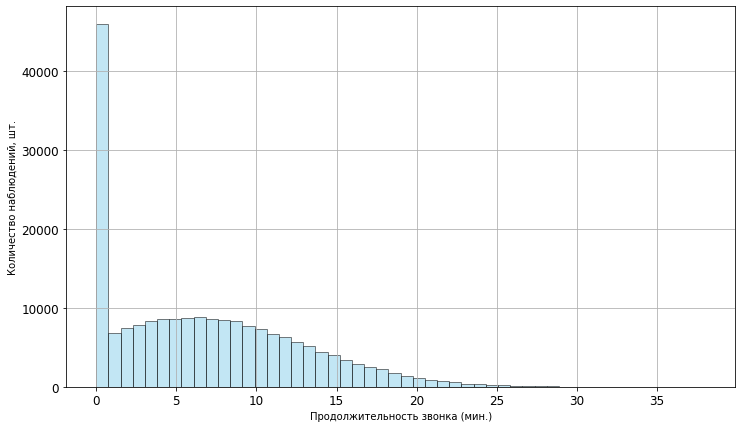

In [27]:
calls['duration'].plot(
    kind='hist',
    alpha=.5,
    grid=True,
    bins=50,
    color="skyblue",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

plt.xlabel('Продолжительность звонка (мин.)')
plt.ylabel('Количество наблюдений, шт.')
plt.show()

На гистограмме мы видим выбивающиеся значения по пропущенным вызовам, продолжительность которых равна нулю. В основном пользователи предпочитают формат "small talk" не более 15 минут, никаких длительных многочасовых разговоров не наблюдаем. Есть редкие любители поговорить до получаса.

Построим гистограмму "Количество отправленных сообщений" для выявления  ошибочных значений и аномальных данных.

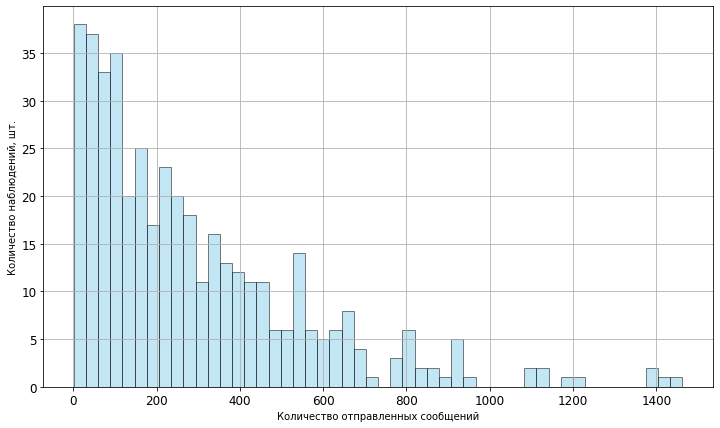

In [28]:
messages.groupby('user_id')['id'].count().plot(
    kind='hist',
    alpha=.5,
    grid=True,
    bins=50,
    color="skyblue",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Количество наблюдений, шт.')
plt.show()

На гистограмме видим, что менбше 5 пользователей отправляют по 1000 сообщений и больше. Предположим, это не ошибки в данных, а те пользователи, которые часто сбрасывают входящие звонки и отправляют сообщение о том, что заняты и не могут говорить.

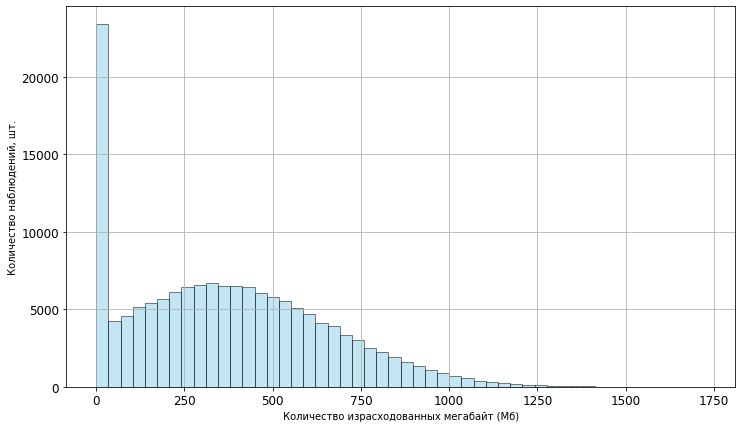

In [29]:
internet['mb_used'].plot(
    kind='hist',
    alpha=.5,
    grid=True,
    bins=50,
    color="skyblue",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

plt.xlabel('Количество израсходованных мегабайт (Мб)')
plt.ylabel('Количество наблюдений, шт.')
plt.show()

На гистограмме видим более 20 тысяч прерванных интернет-сессий (значения около 0 мегабайт), возможно это связано с отсутствием сети или отменой запроса. 

### Вывод

В ходе предобработки мы заменили типы данных, привели названия столбцов к единому виду, чтоб не возникало проблем при объединении таблиц. Критичных ошибок в данных мы не обнаружили. Лишний безымянный столбец в таблице с информацией об интернет-сессиях удалили.


Данные собраны из 5 источников, следует объединить информацию в одну таблицу и сделать дополнительные расчёты для более точного исследования.

## Расчёты и добавление результатов в таблицу

### Звонки
По условиям оператора каждый звонок округляется отдельно в большую сторону. Округлим значения в столбце "Продолжительность разговора" до целого числа в большую сторону.

In [30]:
calls['duration'] = calls['duration'].apply(np.ceil)

# проверка
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Добавим в таблицу "Информация о звонках" столбец "Месяц"

In [31]:
calls['month'] = calls['call_date'].dt.month

# проверка
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам. И сохраним полученные данные в переменную calls_total.

In [32]:
calls_total = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
calls_total.head()

,user_id,month,duration,id
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


Переименуем в полученной таблице столбцы:
* "Длительность звонка в минутах" на "Израсходованные минуты"
* "Уникальный номер звонка" на "Количество звонков за месяц"

In [33]:
calls_total.columns=['user_id', 'month', 'spent_minutes','calls_per_month']
calls_total.head()

,user_id,month,spent_minutes,calls_per_month
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


### Сообщения
Добавим в таблицу "Информация о сообщениях" столбец "Месяц"

In [34]:
messages['month'] = messages['message_date'].dt.month

# проверка
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам, сохраним полученные данные в переменную messages_total.

In [35]:
messages_total = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_total.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Переименуем в полученной таблице столбец "Уникальный номер сообщения" на "Отправленные сообщения".

In [36]:
messages_total.columns=['user_id', 'month', 'sent_messages']
messages_total.head()

,user_id,month,sent_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Интернет-сессии
Добавим в таблицу "Информация об интернет-сессиях" столбец "Месяц"

In [37]:
internet['month'] = internet['session_date'].dt.month

# проверка
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Посчитаем для каждого пользователя количество израсходованного интернет-трафика по месяцам, сохраним полученные данные в переменную internet_total.

In [38]:
internet_total = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
internet_total.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Переименуем в полученной таблице столбец "Объем потраченного за сессию интернет-трафика" на "Израсходованный интернет-трафик за месяц".

In [39]:
internet_total.columns=['user_id', 'month', 'spent_traffic']
internet_total.head()

,user_id,month,spent_traffic
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Округлим данные в столбце "Израсходованный интернет-трафик за месяц" до гигабайт по условиям тарифа.

In [40]:
internet_total['spent_traffic'] = (internet_total['spent_traffic']/1024).apply(np.ceil)
internet_total.head()

,user_id,month,spent_traffic
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


### Объединение таблиц
Объединим таблицы "Информация о звонках" и "Информация о сообщениях" и сохраним в переменную provider.

In [41]:
provider = calls_total.merge(messages_total, on = ['user_id', 'month'], how = 'outer')
provider.head(10)

,user_id,month,spent_minutes,calls_per_month,sent_messages
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0
5,1000,10,350.0,57.0,73.0
6,1000,11,338.0,43.0,58.0
7,1000,12,333.0,46.0,70.0
8,1001,11,430.0,59.0,NaN
9,1001,12,414.0,63.0,NaN


Теперь добавим таблицу "Информация об интернет-сессиях".

In [42]:
provider = provider.merge(internet_total, on = ['user_id', 'month'], how = 'outer')
provider.head(10)

,user_id,month,spent_minutes,calls_per_month,sent_messages,spent_traffic
0,1000,5,159.0,22.0,22.0,3.0
1,1000,6,172.0,43.0,60.0,23.0
2,1000,7,340.0,47.0,75.0,14.0
3,1000,8,408.0,52.0,81.0,14.0
4,1000,9,466.0,58.0,57.0,15.0
5,1000,10,350.0,57.0,73.0,15.0
6,1000,11,338.0,43.0,58.0,15.0
7,1000,12,333.0,46.0,70.0,10.0
8,1001,11,430.0,59.0,NaN,18.0
9,1001,12,414.0,63.0,NaN,14.0


Объединим теперь таблицы с информацией о клиентах и информацией о тарифах  и сохраним в переменную users_and_tariffs.

In [43]:
users_and_tariffs = users.merge(tariffs, on = ['tariff'], how = 'left')
users_and_tariffs.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,15.0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,15.0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,30.0
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,15.0
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,50,15360,500,550,200,3,3,15.0
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,50,15360,500,550,200,3,3,15.0
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,50,15360,500,550,200,3,3,15.0
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart,50,15360,500,550,200,3,3,15.0


Теперь объединим две полученные таблицы:
* информация об услугах
* информация о клиентах и тарифах.

Сохраним общую таблицу в переменную df.

In [44]:
df = users_and_tariffs.merge(provider, on = 'user_id', how = 'left')
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month,spent_minutes,calls_per_month,sent_messages,spent_traffic
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,5.0,159.0,22.0,22.0,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,6.0,172.0,43.0,60.0,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,7.0,340.0,47.0,75.0,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,8.0,408.0,52.0,81.0,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,9.0,466.0,58.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,...,550,200,3,3,15.0,10.0,247.0,41.0,42.0,21.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,9.0,70.0,9.0,11.0,2.0
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,10.0,449.0,68.0,48.0,18.0
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,11.0,612.0,74.0,59.0,18.0


Проверим объединенную таблицу на наличие пропущенных данных.

In [45]:
df.isna().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
month                       2
spent_minutes              42
calls_per_month            42
sent_messages             499
spent_traffic              13
dtype: int64

В объединенной таблице появились пропущенные значения у клиентов, которые не совершали звонки или не отправляли сообщения или не заходили в интернет. Количество клиентов, которые не потратили ни одной минуты и количество клиентов, у которых нет ни одного звонка, совпадают. Значит, что это не ошибка в данных, это действительно клиенты, которые предпочитают звонкам другие способы связи. 


Заменим пропущенные значения на 0 в столбцах:
* "Израсходованные минуты",
* "Количество звонков за месяц",
* "Отправленные сообщения",
* "Израсходованный интернет-трафик за месяц".

In [46]:
pd.set_option('mode.chained_assignment', None)

df['spent_minutes'] = df['spent_minutes'].fillna(0)
df['calls_per_month'] = df['calls_per_month'].fillna(0)
df['sent_messages'] = df['sent_messages'].fillna(0)
df['spent_traffic'] = df['spent_traffic'].fillna(0)

# проверка
df.isna().sum()

user_id                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
month                       2
spent_minutes               0
calls_per_month             0
sent_messages               0
spent_traffic               0
dtype: int64

Посмотрим есть ли клиенты, которые не пользовались никакими услугами.

In [47]:
df_not_active_clients = df[(df['spent_minutes'] == 0) & (df['sent_messages'] == 0) & (df['spent_traffic'] == 0)]
df_not_active_clients

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month,spent_minutes,calls_per_month,sent_messages,spent_traffic
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,...,1950,150,1,1,30.0,NaN,0.0,0.0,0.0,0.0
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,...,550,200,3,3,15.0,NaN,0.0,0.0,0.0,0.0


Мы нашли двух клиентов на каждом из тарифных планов, которые не пользовались никакими услугами связи. Первый абонент подключился к тарифу "Ультра" 15 декабря и уже 23 декабря прекратил пользоваться тарифом. Второй абонент подключился к тарифу "Смарт" 25 декабря и через 5 дней перестал быть абонентом "Мегалайн". Такие данные не подходят для целей нашего исследования, поэтому удалим две строки с этими абонентами.

In [48]:
df = df.loc[(df['user_id'] != 1128) & (df['user_id'] != 1371)]
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month,spent_minutes,calls_per_month,sent_messages,spent_traffic
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,5.0,159.0,22.0,22.0,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,6.0,172.0,43.0,60.0,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,7.0,340.0,47.0,75.0,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,8.0,408.0,52.0,81.0,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1950,150,1,1,30.0,9.0,466.0,58.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,...,550,200,3,3,15.0,10.0,247.0,41.0,42.0,21.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,9.0,70.0,9.0,11.0,2.0
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,10.0,449.0,68.0,48.0,18.0
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,...,550,200,3,3,15.0,11.0,612.0,74.0,59.0,18.0


### Выручка с каждого пользователя
Теперь посчитаем помесячную выручку с каждого пользователя следующим образом: 

1. вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика

In [49]:
df['overlimit_minutes'] = df['spent_minutes']-df['minutes_included']
df['overlimit_messages'] = df['sent_messages']-df['messages_included']
df['overlimit_traffic'] = df['spent_traffic']-df['gb_per_month_included']

2. остаток умножаем на значение из тарифного плана

In [50]:
# функция возвращает сумму, оплаченную сверх тарифного плана по трём услугам
def payment_overlimit(row):
    paid_overlimit_minutes = 0
    paid_overlimit_messages = 0
    paid_overlimit_traffic = 0
    if row['overlimit_minutes'] > 0:
        paid_overlimit_minutes = row['overlimit_minutes']*row['rub_per_minute']
    if row['overlimit_messages'] > 0:
        paid_overlimit_messages = row['overlimit_messages']*row['rub_per_message']
    if row['overlimit_traffic'] > 0:
        paid_overlimit_traffic = row['overlimit_traffic']*row['rub_per_gb']
    return paid_overlimit_minutes + paid_overlimit_messages + paid_overlimit_traffic

df['payment_overlimit'] = df.apply(payment_overlimit, axis=1)

3. прибавляем абонентскую плату, соответствующую тарифному плану. Сохраняем результаты вычислений в столбец "Помесячная выручка с каждого пользователя".

In [51]:
df['revenue'] = df['payment_overlimit'] + df['rub_monthly_fee']
df.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,month,spent_minutes,calls_per_month,sent_messages,spent_traffic,overlimit_minutes,overlimit_messages,overlimit_traffic,payment_overlimit,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,5.0,159.0,22.0,22.0,3.0,-2841.0,-978.0,-27.0,0.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,6.0,172.0,43.0,60.0,23.0,-2828.0,-940.0,-7.0,0.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,7.0,340.0,47.0,75.0,14.0,-2660.0,-925.0,-16.0,0.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,8.0,408.0,52.0,81.0,14.0,-2592.0,-919.0,-16.0,0.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,9.0,466.0,58.0,57.0,15.0,-2534.0,-943.0,-15.0,0.0,1950.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,10.0,350.0,57.0,73.0,15.0,-2650.0,-927.0,-15.0,0.0,1950.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,11.0,338.0,43.0,58.0,15.0,-2662.0,-942.0,-15.0,0.0,1950.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,12.0,333.0,46.0,70.0,10.0,-2667.0,-930.0,-20.0,0.0,1950.0
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,...,11.0,430.0,59.0,0.0,18.0,-70.0,-50.0,3.0,600.0,1150.0
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,...,12.0,414.0,63.0,0.0,14.0,-86.0,-50.0,-1.0,0.0,550.0


### Вывод
Мы подготовили данные к исследованию:
* последовательно объединили таблицы в один датафрейм,
* удалили информацию о клиентах, которые не воспользовались ни одной услугой и перестали быть нашими абонентами,
* добавили к таблице необходимые для дальнейшего исследования расчёты по услугам, которыми клиенты пользовались ежемесячно, 
* посчитали помесячную выручку с каждого клиента. 

Теперь рассмотрим поведение клиентов, исходя из выборки.

## Анализ и описание данных

### Описательная статистика по услугам для каждого  тарифа
Посчитаем статистические показатели:
* среднее количество,
* дисперсию
* стандартное отклонение  

для количества минут разговора, которые пользователи каждого тарифа расходуют в месяц.

In [52]:
df.pivot_table(index=['tariff'], 
               values=['spent_minutes'], 
               aggfunc= {'spent_minutes':['mean', 'var', 'std']}).round()        

spent_minutes                 
                mean    std       var
tariff                               
smart          418.0  190.0   36219.0
ultra          527.0  318.0  100874.0

В среднем пользователи тарифа "Ультра" используют каждый месяц 497 минут разговора при том, что в тариф включено 3000 минут.  
В среднем пользователи тарифа "Смарт" используют каждый месяц 395 минут разговора при том, что в тариф включено 500 минут.  

Посчитаем статистические показатели:
* среднее количество,
* дисперсию
* стандартное отклонение  

для количества сообщений, которые пользователи каждого тарифа отправляют в месяц.

In [53]:
df.pivot_table(index=['tariff'], 
               values=['sent_messages'], 
               aggfunc= {'sent_messages':['mean', 'var', 'std']}).round()       

sent_messages              
                mean   std     var
tariff                            
smart           33.0  28.0   797.0
ultra           49.0  48.0  2285.0

В среднем пользователи обоих тарифов не любят отправлять сообщения. 

Посчитаем статистические показатели:
* среднее количество,
* дисперсию
* стандартное отклонение  

для объёма интернет-трафика, который пользователи каждого тарифа расходуют в месяц.

In [54]:
df.pivot_table(index=['tariff'], 
               values=['spent_traffic'], 
               aggfunc= {'spent_traffic':['mean', 'var', 'std']}).round()      

spent_traffic            
                mean   std   var
tariff                          
smart           16.0   6.0  33.0
ultra           19.0  10.0  97.0

В среднем пользователи тарифа "Смарт" расходуют ежемесячно по 16 Гб интернет-трафика, при включенных 15 Гб в абонентскую плату, т.е. чаще выходят за рамки ежемесячного лимита и готовы платить за дополнительный объём интернет-трафика.

### Визуализация данных
Сохраним информацию о пользователях тарифа "Смарт" в переменную df_smart.

In [55]:
df_smart = df[df['tariff'] == 'smart']
df_smart.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,month,spent_minutes,calls_per_month,sent_messages,spent_traffic,overlimit_minutes,overlimit_messages,overlimit_traffic,payment_overlimit,revenue
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,...,11.0,430.0,59.0,0.0,18.0,-70.0,-50.0,3.0,600.0,1150.0
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,...,12.0,414.0,63.0,0.0,14.0,-86.0,-50.0,-1.0,0.0,550.0
10,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,...,6.0,117.0,15.0,4.0,11.0,-383.0,-46.0,-4.0,0.0,550.0
11,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,...,7.0,214.0,26.0,11.0,18.0,-286.0,-39.0,3.0,600.0,1150.0
12,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,...,8.0,289.0,42.0,13.0,20.0,-211.0,-37.0,5.0,1000.0,1550.0


Сохраним информацию о пользователях тарифа "Ультра" в переменную df_ultra.

In [56]:
df_ultra = df[df['tariff'] == 'ultra']
df_ultra.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,month,spent_minutes,calls_per_month,sent_messages,spent_traffic,overlimit_minutes,overlimit_messages,overlimit_traffic,payment_overlimit,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,5.0,159.0,22.0,22.0,3.0,-2841.0,-978.0,-27.0,0.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,6.0,172.0,43.0,60.0,23.0,-2828.0,-940.0,-7.0,0.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,7.0,340.0,47.0,75.0,14.0,-2660.0,-925.0,-16.0,0.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,8.0,408.0,52.0,81.0,14.0,-2592.0,-919.0,-16.0,0.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,9.0,466.0,58.0,57.0,15.0,-2534.0,-943.0,-15.0,0.0,1950.0


Построим гистограмму распределения использованных минут разговора для тарифов "Смарт" и "Ультра". На оси Х отметим количество минут, включенных в каждый тариф.

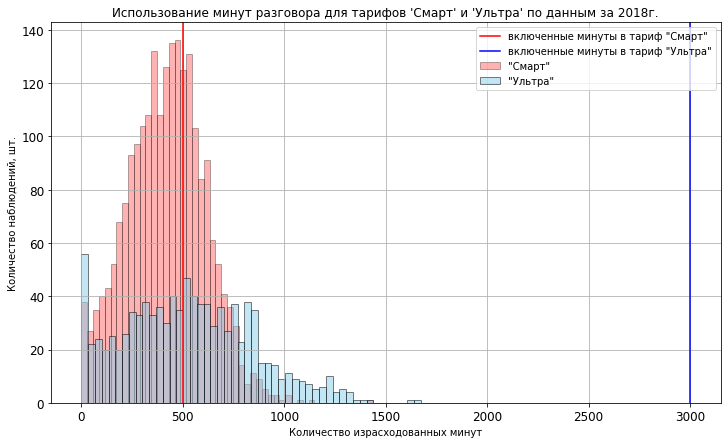

In [57]:
df_smart['spent_minutes'].plot(
    kind='hist',
    alpha=.3,
    grid=True,
    bins=50,
    color="red",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

df_ultra['spent_minutes'].plot(
    kind='hist',
    alpha=.5,
    title="Использование минут разговора для тарифов 'Смарт' и 'Ультра' по данным за 2018г.",
    grid=True,
    bins=50,
    color="skyblue",
    edgecolor="black",
    fontsize=12)

plt.xlabel('Количество израсходованных минут')
plt.ylabel('Количество наблюдений, шт.')
plt.axvline(x=500, color='r')
plt.axvline(x=3000, color='b')
plt.legend(['включенные минуты в тариф "Смарт"', 'включенные минуты в тариф "Ультра"', '"Смарт"', '"Ультра"'], loc=1)
plt.show()

По данным на гистограме мы видим:
* пользователи тарифа "Смарт" чаще превышают количество минут, включенное в абонентскую плату и готовы платить за дополнительные минуты;
* пользователи тарифа "Ультра" укладываются в рамки лимита.

Построим гистограмму распределения отправленных сообщений для тарифов "Смарт" и "Ультра". На оси Х отметим количество сообщений, включенных в каждый тариф.

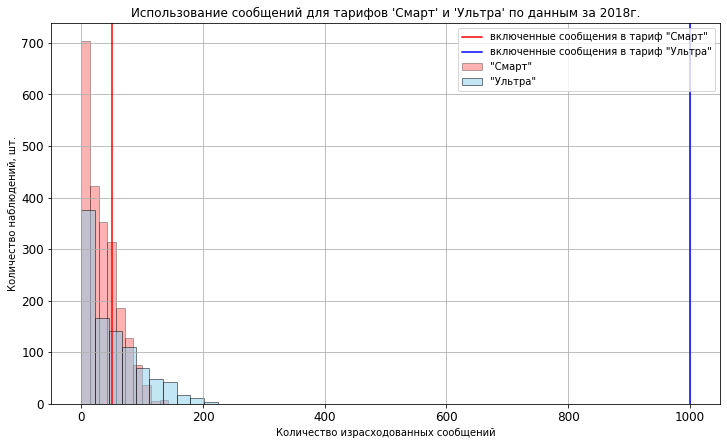

In [58]:
df_smart['sent_messages'].plot(
    kind='hist',
    alpha=.3,
    grid=True,
    color="red",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

df_ultra['sent_messages'].plot(
    kind='hist',
    alpha=.5,
    title="Использование сообщений для тарифов 'Смарт' и 'Ультра' по данным за 2018г.",
    grid=True,
    color="skyblue",
    edgecolor="black",
    fontsize=12)

plt.xlabel('Количество израсходованных сообщений')
plt.ylabel('Количество наблюдений, шт.')
plt.axvline(x=50, color='r')
plt.axvline(x=1000, color='b')
plt.legend(['включенные сообщения в тариф "Смарт"', 'включенные сообщения в тариф "Ультра"', '"Смарт"', '"Ультра"'], loc=1)
plt.show()

Судя по распределению данных на гистограмме, пользователи обоих тарифов не активно отправляют сообщения, особенно пользователи тарифа "Ультра". Клиенты с тарифом "Смарт" отправляют около 50 сообщений в месяц и чаще выходят за пределы лимита, включенного в абонентскую плату. Клиенты с тарифом "Ультра" наоборот не отправляют даже и половины лимита, входящего в абонентскую плату.

Построим гистограмму распределения использованного объёма интернет-трафика для тарифов "Смарт" и "Ультра". На оси Х отметим количество гигабайт, включенных в каждый тариф.

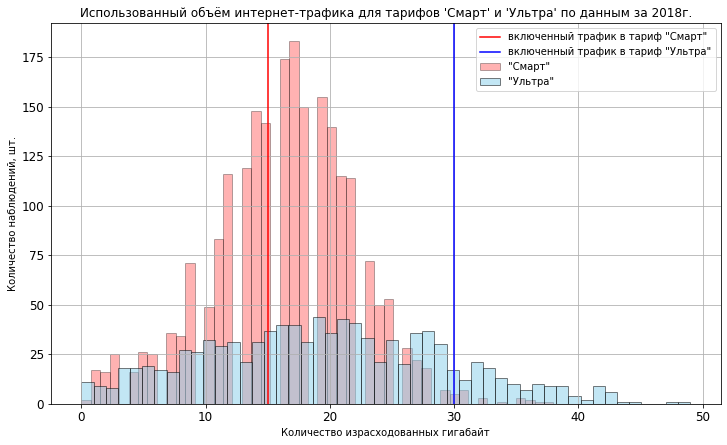

In [59]:
df_smart['spent_traffic'].plot(
    kind='hist',
    alpha=.3,
    grid=True,
    bins=50,
    color="red",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)

df_ultra['spent_traffic'].plot(
    kind='hist',
    alpha=.5,
    title="Использованный объём интернет-трафика для тарифов 'Смарт' и 'Ультра' по данным за 2018г.",
    grid=True,
    bins=50,
    color="skyblue",
    edgecolor="black",
    fontsize=12)

plt.xlabel('Количество израсходованных гигабайт')
plt.ylabel('Количество наблюдений, шт.')
plt.axvline(x=15, color='r')
plt.axvline(x=30, color='b')
plt.legend(['включенный трафик в тариф "Смарт"', 'включенный трафик в тариф "Ультра"', '"Смарт"', '"Ультра"'], loc=1)
plt.show()

По данным гистограммы видно, что пользователи обоих тарифов расходуют интернет-трафик сверх лимитов, включенных в абонентскую плату.

### Вывод

Пользователи более дорого тарифа редко потребляют больше услуг, чем предоплачено по тарифу. Клиенты обоих тарифов активно пользуются интернетом и часто оплачивают дополнительные объемы трафика. Пользователи тарифа "Смарт" активнее совершают звонки, чем клиенты тарифа "Ультра".

## Проверка гипотез 
Поверим гипотезу "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются". Для этого сформулируем нулевую гипотезу, исходя из равенства средних двух генеральных совокупностей:

Н0: Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается,  
H1: Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Для проверки гипотезы используем специальный метод - t-тест, который не требует нормального распределения для генеральных совокупностей.

In [60]:
alpha = .05
results = st.ttest_ind(
    df_smart['revenue'], 
    df_ultra['revenue'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу


Статистически у нас есть основание предполагать, что нулевая гипотеза  не верна, значит, что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается. Подкрепим наш вывод визуально и построим гистограмму средней выручки для каждого тарифа.

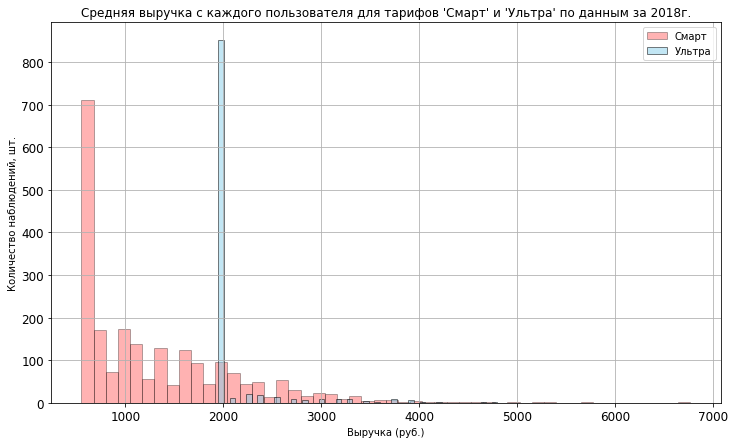

In [61]:
df_smart['revenue'].plot(
    kind='hist',
    alpha=.3,
    label="Смарт",
    grid=True,
    bins = 50,
    color="red",
    edgecolor="black",
    figsize=(12,7),
    fontsize=12)
df_ultra['revenue'].plot(
    kind='hist',
    alpha=.5,
    title="Средняя выручка с каждого пользователя для тарифов 'Смарт' и 'Ультра' по данным за 2018г.",
    label="Ультра",
    grid=True,
    bins = 50,
    color="skyblue",
    edgecolor="black",
    fontsize=12)
plt.xlabel('Выручка (руб.)')
plt.ylabel('Количество наблюдений, шт.')
plt.legend()
plt.show()

Проверим теперь вторую гипотезу "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". Для этого сформулируем нулевую гипотезу, исходя из равенства средних двух генеральных совокупностей:

Н0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов,  
H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотезы используем специальный метод - t-тест, который не требует нормального распределения для генеральных совокупностей.

In [62]:
df_msk = df[df['city'] == 'Москва']
df_regions = df[df['city'] != 'Москва']

alpha = .05
results = st.ttest_ind(
    df_msk['revenue'], 
    df_regions['revenue'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Отвергнуть нулевую гипотезу не получилось, значит, что пользователи тратят на услуги связи в среднем одинаковые суммы как в Москве, так и в других регионах.

## Общий вывод

Объект нашего исследования - данные 500 пользователей федерального оператора сотовой связи «Мегалайн», которые используют два тарифа "Смарт" и "Ультра". 

Предобработка данных обнаружила 2 проблемы:
1. нарушения в стиле заголовков,
2. некорректный тип данных.

Самые критичные ошибки данных мы исправили:
* заменили название столбца "tariff_name" для корректного объединения таблиц, 
* поменяли тип данных на формат даты.

Сделали дополнительные расчёты:
1. в каждую таблицу с информацией по услугам добавили столбец "Месяц",
2. посчитали для каждого пользователя:
  * количество сделанных звонков и израсходованных минут разговора по месяцам,
  * количество отправленных сообщений по месяцам,
  * объем израсходованного интернет-трафика по месяцам,
  * помесячную выручку.

Последовательно объединили таблицы с данными по услугам, пользователям и тарифам.

Таким образом, исследование проводили в 5 этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Расчеты и добавление результатов в таблицу.
 4. Исследовательский анализ данных.
 5. Проверка гипотез.

По результатам исследования данных о пользователях двух тарифных планов сотового оператора "Мегалайн", мы установили, что:
* пользователи более дешевого тарифного плана "Смарт" чаще выходят за рамки лимитов предоплаченных услуг и переплачивают сверх абонентской платы. Это выгодно для сотового оператора, но невыгодно клиентам и они могут уйти к другому оператору, где за такую же абонентскую плату получат бОльший пакет услуг;
* тариф "Ультра" приносит больше денег, чем тариф "Смарт";
* в среднем пользователи из Москвы тратят на услуги связи также как и в других регионах;
* в обоих тарифах клиенты почти не пользуются смс-сообщениями, предпочитая другие способы связи.


Подведём итоги нашей работы - несколько рекомендаций для оператора "Мегалайн":
* Обратить внимание, что пользователи тарифа "Смарт" часто переплачивают за услуги сверх абонентской платы, это может негативно сказаться на их выборе сотового оператора. Возможно стоит пересмотреть пакет услуг тарифа "Смарт";

* Сделать акцент на методе подсчета веб-трафика - округление в большую сторону возможно и приводит к тому, что пользователи обоих тарифов выходят за лимиты тарифного плана.